In [117]:
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sksurv.nonparametric import kaplan_meier_estimator

In [14]:
# helper functions

def featureProportion(path, frac_features, frac_features_names, drop_features):
#     drop_features: list of strings with the names of the categorical features 
#     binary_features: list of string witht the names of the binary columns
#     target_col: string

    df = pd.read_csv(path, low_memory = False)
    df = df.dropna()
    
    total_courses_count = "cnt_courses_in_specialization"
    
    for feature, name in zip(frac_features, frac_features_names):
        
        df[name] = df[feature] / df[total_courses_count]

    df = df.drop(columns = drop_features)
    
    return df

In [15]:

data_descriptions = pd.read_csv('data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,subscription_id,Identifier,character,Unique identifier of each subscription
1,observation_dt,Identifier,date,The date on which the subscription was observed to calculate the features in the dataset. It was chosen at random amongst all the dates between the start of the subscription and the end of the subscription (before cancellation)
2,is_retained,Target,Integer,"TRAINING SET ONLY! 0 = the learner cancelled their subscription before next payment, 1 = the learner made an additional payment in this subscription"
3,specialization_id,Feature - Specialization Info,character,Unique identifier of a specialization (each subscription gives a learner access to a particular specialization)
4,cnt_courses_in_specialization,Feature - Specialization Info,integer,number of courses in the specialization
5,specialization_domain,Feature - Specialization Info,character,"primary domain of the specialization (Computer Science, Data Science, etc.)"
6,is_professional_certificate,Feature - Specialization Info,boolean,"BOOLEAN for whether the specialization is a ""professional certicate"" (a special type of specialization that awards completers with an industry-sponsored credential)"
7,is_gateway_certificate,Feature - Specialization Info,boolean,"BOOLEAN for whether the specialization is a ""gateway certificate"" (a special type of specialization geared towards learners starting in a new field)"
8,learner_days_since_registration,Feature - Learner Info,integer,Days from coursera registration date to the date on which the observation is made
9,learner_country_group,Feature - Learner Info,character,"the region of the world that the learner is from (United States, East Asia, etc.)"


#### load the data

In [93]:
dataset = pd.read_csv("dataset.csv", low_memory = False)

dataset.shape

(413955, 37)

In [94]:
dataset.head()

,subscription_id,observation_dt,is_retained,specialization_id,cnt_courses_in_specialization,specialization_domain,is_professional_certificate,is_gateway_certificate,learner_days_since_registration,learner_country_group,...,cnt_enrollments_completed_during_payment_period,cnt_enrollments_active_during_payment_period,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,is_active_capstone_during_pay_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity
0,--rKikbGEeyQHQqIvaM5IQ,2022-05-04,1.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,2321.0,Northern Europe,...,0.0,0.0,0.0,0.0,False,73.783333,0.000000,68.0,0.0,20.0
1,-0XGzEq2EeyimBISGRuNeQ,2021-11-30,0.0,Q0Fc_Yl0EeqdTApgQ4tM7Q,6.0,Data Science,True,False,612.0,Northern Europe,...,0.0,0.0,0.0,0.0,False,0.850000,0.000000,7.0,2.0,0.0
2,-1P9kOb6EeuRugq1Liq62w,2021-08-13,0.0,9kmimrDIEeqxzQqieMm42w,6.0,Business,True,True,27.0,Australia and New Zealand,...,0.0,1.0,12.0,2.0,False,1.833333,2.983333,2.0,1.0,18.0
3,-2ifTJZbEeuIuRKpAhovaw,2021-08-03,1.0,7lHCSlFIEeeffRIHljDI_g,5.0,Information Technology,True,True,120.0,United States,...,0.0,2.0,83.0,9.0,False,18.450000,7.100000,18.0,4.0,3.0
4,-5YKZbchEeufeAq6C_fAOw,2021-06-04,0.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,1228.0,India,...,1.0,1.0,61.0,4.0,False,29.566667,15.250000,18.0,8.0,1.0


In [95]:
dataset.columns

Index(['subscription_id', 'observation_dt', 'is_retained', 'specialization_id',
       'cnt_courses_in_specialization', 'specialization_domain',
       'is_professional_certificate', 'is_gateway_certificate',
       'learner_days_since_registration', 'learner_country_group',
       'learner_gender', 'learner_cnt_other_courses_active',
       'learner_cnt_other_courses_paid_active',
       'learner_cnt_other_courses_items_completed',
       'learner_cnt_other_courses_paid_items_completed',
       'learner_cnt_other_transactions_past', 'learner_other_revenue',
       'subscription_period_order', 'days_since_last_payment',
       'days_til_next_payment_due',
       'cnt_enrollments_started_before_payment_period',
       'cnt_enrollments_completed_before_payment_period',
       'cnt_enrollments_active_before_payment_period',
       'cnt_items_completed_before_payment_period',
       'cnt_graded_items_completed_before_payment_period',
       'is_subscription_started_with_free_trial',
      

In [96]:
dataset.head()

,subscription_id,observation_dt,is_retained,specialization_id,cnt_courses_in_specialization,specialization_domain,is_professional_certificate,is_gateway_certificate,learner_days_since_registration,learner_country_group,...,cnt_enrollments_completed_during_payment_period,cnt_enrollments_active_during_payment_period,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,is_active_capstone_during_pay_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity
0,--rKikbGEeyQHQqIvaM5IQ,2022-05-04,1.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,2321.0,Northern Europe,...,0.0,0.0,0.0,0.0,False,73.783333,0.000000,68.0,0.0,20.0
1,-0XGzEq2EeyimBISGRuNeQ,2021-11-30,0.0,Q0Fc_Yl0EeqdTApgQ4tM7Q,6.0,Data Science,True,False,612.0,Northern Europe,...,0.0,0.0,0.0,0.0,False,0.850000,0.000000,7.0,2.0,0.0
2,-1P9kOb6EeuRugq1Liq62w,2021-08-13,0.0,9kmimrDIEeqxzQqieMm42w,6.0,Business,True,True,27.0,Australia and New Zealand,...,0.0,1.0,12.0,2.0,False,1.833333,2.983333,2.0,1.0,18.0
3,-2ifTJZbEeuIuRKpAhovaw,2021-08-03,1.0,7lHCSlFIEeeffRIHljDI_g,5.0,Information Technology,True,True,120.0,United States,...,0.0,2.0,83.0,9.0,False,18.450000,7.100000,18.0,4.0,3.0
4,-5YKZbchEeufeAq6C_fAOw,2021-06-04,0.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,1228.0,India,...,1.0,1.0,61.0,4.0,False,29.566667,15.250000,18.0,8.0,1.0


In [97]:
dataset.specialization_domain.unique()

array(['Data Science', 'Business', 'Information Technology',
       'Computer Science', 'Arts and Humanities', 'Language Learning',
       'Health', 'Physical Science and Engineering', 'Social Sciences',
       'Personal Development', 'Math and Logic', nan], dtype=object)

In [25]:
# convert integers of course enrollment to fractions
frac_features = ["cnt_enrollments_started_before_payment_period", 
                                    "cnt_enrollments_completed_before_payment_period", 
                                    "cnt_enrollments_active_before_payment_period", 
                                    "cnt_enrollments_started_during_payment_period", 
                                    "cnt_enrollments_completed_during_payment_period", 
                                    "cnt_enrollments_active_during_payment_period",]

frac_features_names = ["frc_enrollments_started_before_payment_period", 
                       "frc_enrollments_completed_before_payment_period", 
                       "frc_enrollments_active_before_payment_period", 
                       "frc_enrollments_started_during_payment_period", 
                       "frc_enrollments_completed_during_payment_period", 
                       "frc_enrollments_active_during_payment_period",]

# drop the categorical features
drop_features = ["cnt_enrollments_started_before_payment_period", 
                 "cnt_enrollments_completed_before_payment_period", 
                 "cnt_enrollments_active_before_payment_period", 
                 "cnt_enrollments_started_during_payment_period", 
                 "cnt_enrollments_completed_during_payment_period", 
                 "cnt_enrollments_active_during_payment_period",]

In [112]:
# preprocessing training set
path_data = "dataset.csv"
dataset = featureProportion(path_data, frac_features, frac_features_names, drop_features)

# time and event columns
time_col = "learner_days_since_registration"
event_col = "is_retained"

In [113]:
dataset.columns

Index(['subscription_id', 'observation_dt', 'is_retained', 'specialization_id',
       'cnt_courses_in_specialization', 'specialization_domain',
       'is_professional_certificate', 'is_gateway_certificate',
       'learner_days_since_registration', 'learner_country_group',
       'learner_gender', 'learner_cnt_other_courses_active',
       'learner_cnt_other_courses_paid_active',
       'learner_cnt_other_courses_items_completed',
       'learner_cnt_other_courses_paid_items_completed',
       'learner_cnt_other_transactions_past', 'learner_other_revenue',
       'subscription_period_order', 'days_since_last_payment',
       'days_til_next_payment_due',
       'cnt_items_completed_before_payment_period',
       'cnt_graded_items_completed_before_payment_period',
       'is_subscription_started_with_free_trial',
       'cnt_items_completed_during_payment_period',
       'cnt_graded_items_completed_during_payment_period',
       'is_active_capstone_during_pay_period',
       'sum_hours

In [114]:
# from categorical to numerical features

dataset = dataset.drop(columns = "learner_gender")

categories = ["specialization_domain", "is_professional_certificate", "is_gateway_certificate", 
              "learner_country_group", "is_subscription_started_with_free_trial", 
              "is_active_capstone_during_pay_period"]



In [155]:
N_null = sum(dataset[features].isnull().sum())
print("The coursera subscription dataset contains {} null values.".format(N_null))

The coursera subscription dataset contains 0 null values.


#### KM Survival curves

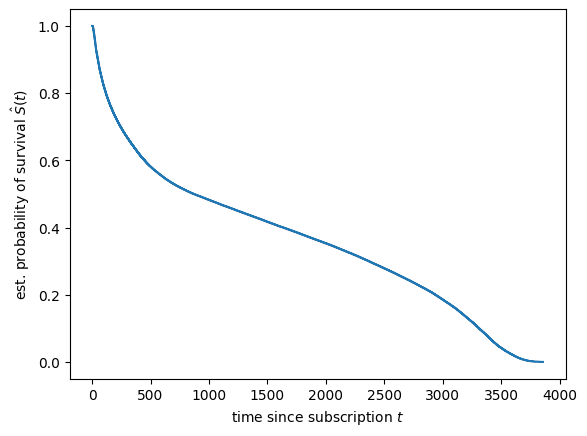

In [153]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    dataset[event_col].values.astype(bool), dataset[time_col].values, 
    conf_type="log-log")

plt.step(time, survival_prob)
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.1, color = "red")

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time since subscription $t$")

#plt.xlim(left = 3500, right = 3600)
#plt.ylim(top = 1, bottom = 0.9)
plt.show()

##### Survival curves for subscribers that started using free trial and paid subscriptions 

In [190]:
# filter out the subscriptions that started as a free trial and explore the survival curves for both groups

free_trial_dataset = dataset[dataset["is_subscription_started_with_free_trial"]]
paid_subs_dataset = dataset[dataset["is_subscription_started_with_free_trial"] == False]

free_time, free_survival_prob, free_conf_int = kaplan_meier_estimator(
    free_trial_dataset[event_col].values.astype(bool), free_trial_dataset[time_col].values, 
    conf_type="log-log")

paid_time, paid_survival_prob, paid_conf_int = kaplan_meier_estimator(
    paid_subs_dataset[event_col].values.astype(bool), paid_subs_dataset[time_col].values, 
    conf_type="log-log")

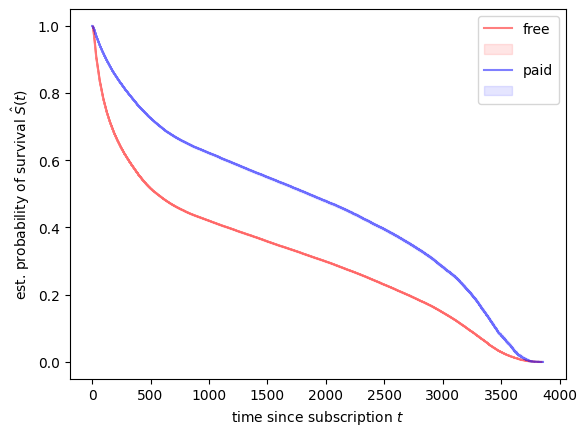

In [203]:
plt.step(free_time, free_survival_prob, color = "red", alpha = 0.5)
plt.fill_between(free_time, free_conf_int[0], free_conf_int[1], alpha=0.1, color = "red")

plt.step(paid_time, paid_survival_prob, color = "blue", alpha = 0.5)
plt.fill_between(paid_time, paid_conf_int[0], paid_conf_int[1], alpha=0.1, color = "blue")

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time since subscription $t$")

plt.legend(["free", "", "paid",""], loc = "best")

plt.show()

##### Different specialization domains

In [205]:
dataset.specialization_domain.unique()

array(['Data Science', 'Business', 'Information Technology',
       'Computer Science', 'Arts and Humanities', 'Language Learning',
       'Health', 'Physical Science and Engineering', 'Social Sciences',
       'Personal Development', 'Math and Logic'], dtype=object)

In [223]:
ds_dataset = dataset[dataset["specialization_domain"] == "Data Science"]
business_dataset = dataset[dataset["specialization_domain"] == "Business"]

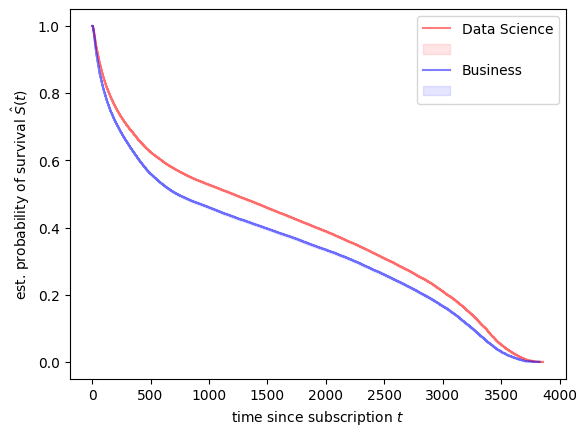

In [226]:
ds_time, ds_survival_prob, ds_conf_int = kaplan_meier_estimator(
    ds_dataset[event_col].values.astype(bool), ds_dataset[time_col].values, 
    conf_type="log-log")
business_time, business_survival_prob, business_conf_int = kaplan_meier_estimator(
    business_dataset[event_col].values.astype(bool), business_dataset[time_col].values, 
    conf_type="log-log")

plt.step(ds_time, ds_survival_prob, color = "red", alpha = 0.5)
plt.fill_between(ds_time, ds_conf_int[0], ds_conf_int[1], alpha=0.1, color = "red")

plt.step(business_time, business_survival_prob, color = "blue", alpha = 0.5)
plt.fill_between(business_time, business_conf_int[0], business_conf_int[1], alpha=0.1, color = "blue")

plt.legend(["Data Science", "", "Business", ""], loc = "best")

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time since subscription $t$")

plt.show()

#### survival model

In [108]:
import sys

sys.version_info

sys.version_info(major=3, minor=9, micro=18, releaselevel='final', serial=0)